# Greedy & Gurobi

## MK

In [14]:
!pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
from gurobipy import Model, GRB, quicksum

def solve_mk_gurobi(weights, values, capacities):
    """
    Resuelve el multiple knapsack multidimensional con Gurobi.

    Parámetros:
        weights:    array (n_items, n_dims)
        values:     array (n_items,)
        capacities: array (n_knapsacks, n_dims)

    Devuelve:
        best_solution: vector de largo n_items con la mochila de cada ítem (o -1)
        best_value:    valor total óptimo
    """
    n_items, n_dims = weights.shape
    n_knapsacks = capacities.shape[0]

    m = Model("multiple_knapsack")
    m.Params.OutputFlag = 0  # silenciar salida

    items = range(n_items)
    knapsacks = range(n_knapsacks)
    dims = range(n_dims)

    # Variables x[i,k] = 1 si el ítem i va a la mochila k
    x = m.addVars(items, knapsacks, vtype=GRB.BINARY, name="x")

    # Objetivo: maximizar sum(values[i] * x[i,k])
    m.setObjective(
        quicksum(values[i] * x[i, k] for i in items for k in knapsacks),
        GRB.MAXIMIZE
    )

    # Restricciones de capacidad en cada mochila y dimensión
    for k in knapsacks:
        for d in dims:
            m.addConstr(
                quicksum(weights[i, d] * x[i, k] for i in items)
                <= capacities[k, d],
                name=f"cap_{k}_{d}"
            )

    # Cada ítem a lo sumo en una mochila
    for i in items:
        m.addConstr(
            quicksum(x[i, k] for k in knapsacks) <= 1,
            name=f"assign_item_{i}"
        )

    # Resolver
    m.optimize()

    best_solution = -1 * np.ones(n_items, dtype=int)
    best_value = None

    if m.status == GRB.OPTIMAL:
        best_value = m.objVal
        for i in items:
            for k in knapsacks:
                if x[i, k].X > 0.5:
                    best_solution[i] = k

    return best_solution, best_value


In [16]:
import numpy as np

def greedy_multiple_knapsack(weights, values, capacities):
    """
    Greedy para el problema de múltiples mochilas multidimensionales.

    weights: (n_items, n_dims)
    values:  (n_items,)
    capacities: (n_knapsacks, n_dims)

    Devuelve:
      - solution: vector de largo n_items con la mochila asignada (0..K-1) o -1 si no se usa
      - total_value: valor total conseguido
      - remaining: capacidades restantes por mochila y dimensión
    """
    n_items, n_dims = weights.shape
    n_knapsacks = capacities.shape[0]

    # "Tamaño" de cada ítem (suma de pesos en todas las dimensiones)
    sizes = weights.sum(axis=1).astype(float)
    # Evitar división por cero si algún ítem tiene pesos cero en todas las dims
    sizes[sizes == 0] = 1e-9

    # Score greedy: valor / tamaño
    scores = values / sizes

    # Ordenar ítems por score decreciente
    order = np.argsort(-scores)

    # Solución: -1 = no asignado
    solution = -np.ones(n_items, dtype=int)
    # Capacidades restantes
    remaining = capacities.astype(float).copy()

    for i in order:
        best_k = None
        best_slack = None

        # Probar todas las mochilas en las que quepa el ítem
        for k in range(n_knapsacks):
            if np.all(remaining[k] >= weights[i]):
                # Slack total si metemos el ítem en la mochila k
                slack = np.sum(remaining[k] - weights[i])
                if best_k is None or slack < best_slack:
                    best_k = k
                    best_slack = slack

        # Si encontramos alguna mochila factible, asignamos
        if best_k is not None:
            solution[i] = best_k
            remaining[best_k] -= weights[i]

    # Calcular valor total de la solución
    total_value = sum(values[i] for i in range(n_items) if solution[i] != -1)

    return solution, total_value, remaining


## MCMKP

In [17]:
import numpy as np
from gurobipy import Model, GRB, quicksum

def greedy_mcmkp(profits, weights, capacities, classes):
    """
    Greedy algorithm for the Multiple-Choice Multidimensional Knapsack Problem.

    Parameters:
    - profits: (n_items, n_classes) array of item profits
    - weights: (n_items, n_classes, n_resources) array of item weights
    - capacities: (n_resources,) array of knapsack capacities
    - classes: (n_items,) array of item class indices

    Returns:
    - solution: vector of length n_classes with the selected item index
    - total_profit: total profit of the solution
    """
    n_items, n_classes = profits.shape
    n_resources = capacities.shape[0]

    # Initialize solution with -1 (no item selected)
    solution = -1 * np.ones(n_classes, dtype=int)

    # Initialize remaining capacities
    remaining_capacities = capacities.copy()

    # Iterate over classes
    for c in range(n_classes):
        # Get items in the current class
        items_in_class = np.where(classes == c)[0]

        # Find the item with the highest profit-to-weight ratio
        best_item = None
        best_ratio = -np.inf
        for i in items_in_class:
            # Check if the item fits in the remaining capacities
            if np.all(weights[i, c, :] <= remaining_capacities):
                # Calculate the profit-to-weight ratio
                ratio = profits[i, c] / np.sum(weights[i, c, :])
                if ratio > best_ratio:
                    best_item = i
                    best_ratio = ratio

        # If an item is found, add it to the solution
        if best_item is not None:
            solution[c] = best_item
            remaining_capacities -= weights[best_item, c, :]

    # Calculate the total profit
    total_profit = np.sum([profits[i, c] for c, i in enumerate(solution) if i != -1])

    return solution, total_profit

In [18]:
def solve_mcmkp_gurobi(profits, weights, capacities, classes):
    """
    Solve the Multiple-Choice Multidimensional Knapsack Problem using Gurobi.

    Parameters:
    - profits: (n_items, n_classes) array of item profits
    - weights: (n_items, n_classes, n_resources) array of item weights
    - capacities: (n_resources,) array of knapsack capacities
    - classes: (n_items,) array of item class indices

    Returns:
    - solution: vector of length n_classes with the selected item index
    - total_profit: total profit of the solution
    """
    n_items, n_classes = profits.shape
    n_resources = capacities.shape[0]

    # Create a Gurobi model
    m = Model("MCMKP")
    m.Params.OutputFlag = 0  # silence output

    # Create variables
    x = m.addVars(n_items, n_classes, vtype=GRB.BINARY, name="x")

    # Objective function
    m.setObjective(quicksum(profits[i, c] * x[i, c] for i in range(n_items) for c in range(n_classes)), GRB.MAXIMIZE)

    # Constraints
    for r in range(n_resources):
        m.addConstr(quicksum(weights[i, c, r] * x[i, c] for i in range(n_items) for c in range(n_classes)) <= capacities[r])

    for c in range(n_classes):
        m.addConstr(quicksum(x[i, c] for i in range(n_items)) == 1)

    # Solve the model
    m.optimize()

    # Get the solution
    solution = -1 * np.ones(n_classes, dtype=int)
    total_profit = 0
    if m.status == GRB.OPTIMAL:
        total_profit = m.objVal
        for c in range(n_classes):
            for i in range(n_items):
                if x[i, c].X > 0.5:
                    solution[c] = i

    return solution, total_profit

# Clases

## MK

In [19]:
import numpy as np
import random
from math import exp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class MultipleKnapsack:
    def __init__(self, weights, values, capacities, T=600, L=0.9999, start_with_greedy=False):
        """
        Initialize the problem instance.

        Parameters:
        - weights: (n_items, n_dims) array of item weights
        - values: (n_items,) array of item values
        - capacities: (n_knapsacks, n_dims) array of capacities for each knapsack and dimension
        - T: initial temperature
        - L: reduction rate
        - start_with_greedy: whether to start with a greedy solution
        """

        self.weights = weights
        self.values = values
        self.capacities = capacities

        self.n_items = len(values)
        self.n_knapsacks = len(capacities)
        self.n_dims = weights.shape[1]

        if start_with_greedy:
            self.solution, _, _ = greedy_multiple_knapsack(weights, values, capacities)
        else:
            # Initial solution: all items unassigned (-1)
            self.solution = [-1] * self.n_items

        self.best_solution = list(self.solution)

        # Track current usage of capacities in each knapsack
        self.usage = np.zeros((self.n_knapsacks, self.n_dims), dtype=int)

        self.T = T  # initial temperature
        self.L = L  # reduction rate

    def compute_value(self, solution):
        """Compute total value of a solution."""
        return sum(self.values[i] for i in range(self.n_items) if solution[i] != -1)

    def compute_usage(self, solution):
        """Compute total usage per knapsack per dimension for a given solution."""
        usage = np.zeros((self.n_knapsacks, self.n_dims), dtype=int)
        for i in range(self.n_items):
            k = solution[i]
            if k != -1:
                usage[k] += self.weights[i]
        return usage

    def is_feasible(self, solution):
        """Check if solution is valid: all knapsack constraints respected."""
        usage = self.compute_usage(solution)
        return np.all(usage <= self.capacities)

    # ---- New helper methods for incremental updates ----

    def validar_agregar(self, item, knapsack):
        """Check if adding item to knapsack is feasible."""
        return np.all(self.usage[knapsack] + self.weights[item] <= self.capacities[knapsack])

    def agregar(self, item, knapsack):
        """Assign item to knapsack, updating usage."""
        if not self.validar_agregar(item, knapsack):
            return False
        self.solution[item] = knapsack
        self.usage[knapsack] += self.weights[item]
        return True

    def quitar(self, item):
        """Remove item from its assigned knapsack, updating usage."""
        knapsack = self.solution[item]
        if knapsack == -1:
            return False
        self.solution[item] = -1
        self.usage[knapsack] -= self.weights[item]
        return True

    def flip(self, item, knapsack):
        """
        Flip assignment of item:
        - Remove current assignment (if any)
        - Assign to new knapsack (if not -1)
        """
        current_knapsack = self.solution[item]
        if current_knapsack != -1:
            self.usage[current_knapsack] -= self.weights[item]
        if knapsack != -1:
            if self.validar_agregar(item, knapsack):
                self.solution[item] = knapsack
                self.usage[knapsack] += self.weights[item]
                return True
            else:
                # revert usage if not feasible
                if current_knapsack != -1:
                    self.usage[current_knapsack] += self.weights[item]
                return False
        else:
            # unassign item
            self.solution[item] = -1
            return True

    # ---- Updated neighbor generation ----

    def generate_neighbor(self):
        """
        Generate a valid neighbor solution by flipping the assignment of a single item:
        either unassign it, assign it to a new knapsack, or move it from one knapsack to another.
        """
        neighbor = list(self.solution)
        usage_backup = np.copy(self.usage)

        item = random.randint(0, self.n_items - 1)
        current_knapsack = neighbor[item]

        options = list(range(-1, self.n_knapsacks))
        if current_knapsack != -1:
            options.remove(current_knapsack)
        random.shuffle(options)

        for new_knapsack in options:
            # Try flip
            # Temporarily update solution and usage
            # Use flip logic to check feasibility incrementally
            self.solution = list(neighbor)
            self.usage = np.copy(usage_backup)

            if self.flip(item, new_knapsack):
                return list(self.solution)

        # No feasible neighbor found, revert
        self.solution = list(neighbor)
        self.usage = np.copy(usage_backup)
        return neighbor

    def run(self, iterations=10000, verbose=False, beta_func=None):
        """Run the Simulated Annealing metaheuristic."""
        # Initialize usage for initial solution
        self.usage = self.compute_usage(self.solution)
        value = self.compute_value(self.solution)
        best_value = value
        best_solution = list(self.solution)
        T = self.T
        self.cost_history = []

        for it in range(1, iterations + 1):
            neighbor = self.generate_neighbor()
            neighbor_value = self.compute_value(neighbor)
            delta = neighbor_value - value

            if delta >= 0 or random.random() < exp(delta / T):
                self.solution = neighbor
                self.usage = self.compute_usage(self.solution)  # keep usage consistent
                value = neighbor_value

                if neighbor_value > best_value:
                    best_value = neighbor_value
                    best_solution = list(neighbor)

            if beta_func is None:
                T *= self.L  # cool down
            else:
                T = self.T / beta_func(it)

            #self.cost_history.append((value, best_value, T, list(self.solution)))  # Track current value, best value, and temperature
            self.cost_history.append((list(self.solution), value, best_value, T))

            if verbose and it % 500 == 0:
                print(f"[Iter {it}] Current value: {value} | Best value: {best_value} | T = {T:.4f}")

        self.best_solution = best_solution

        if verbose:
            self.print_solution(best_solution)

    def plot_cost_history(self):
        """Plot the cost function along iterations."""
        current_values = [x[1] for x in self.cost_history]
        best_values = [x[2] for x in self.cost_history]
        temperatures = [x[3] for x in self.cost_history]

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        axs[0].plot(current_values, label='Current Value')
        axs[0].plot(best_values, label='Best Value')
        axs[0].set_title('Cost Function along Iterations')
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Value')
        axs[0].legend()

        axs[1].plot(temperatures)
        axs[1].set_title('Temperature along Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Temperature')

        plt.tight_layout()
        plt.show()

    def plot_knapsack_usage(self):
        """Plot knapsack usage."""
        n_knapsacks = self.capacities.shape[0]

        if len(self.capacities.shape) > 1:
            n_dims = self.capacities.shape[1]
        else:
            n_dims = 1
            self.capacities = self.capacities[:, np.newaxis]  # Convert to 2D array

        usage = np.zeros_like(self.capacities)
        values_per_knapsack = np.zeros(n_knapsacks)

        for i, k in enumerate(self.best_solution):
            if k != -1:
                usage[k] += self.weights[i]
                values_per_knapsack[k] += self.values[i]

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))

        # Bar plot: used weight vs capacity per knapsack per dimension
        width = 0.35
        x = np.arange(n_knapsacks)

        for dim in range(n_dims):
            bars = axs[0].bar(x - width/2 + dim*width/(n_dims), usage[:, dim], width/(n_dims), label=f'Used dim {dim}')

            # Plot capacity as dotted line
            for k, bar in enumerate(bars):
                axs[0].plot([bar.get_x(), bar.get_x() + bar.get_width()],
                            [self.capacities[k, dim], self.capacities[k, dim]],
                            linestyle='dotted', color='black', linewidth=2)

        axs[0].set_title('Knapsack Capacities vs Used Weights')
        axs[0].set_xlabel('Knapsack')
        axs[0].set_ylabel('Weight')
        axs[0].legend()

        # Bar plot: values per knapsack
        axs[1].bar(x, values_per_knapsack)
        axs[1].set_title('Total Values Packed per Knapsack')
        axs[1].set_xlabel('Knapsack')
        axs[1].set_ylabel('Value')

        plt.tight_layout()
        plt.show()

    def plot_assignment_matrix(self):
        """Plot assignment matrix."""
        n_items = len(self.best_solution)
        X = np.zeros((n_items, self.n_knapsacks))
        for i, k in enumerate(self.best_solution):
            if k != -1:
                X[i, k] = 1

        plt.figure(figsize=(6,6))
        plt.imshow(X, cmap='Greys', interpolation='none')
        plt.title('Item Assignment Matrix (Items x Knapsacks)')
        plt.xlabel('Knapsack')
        plt.ylabel('Item')
        plt.colorbar(label='Assigned (1) or not (0)')
        plt.show()

    def validate_solution(self, solution=None):
        """Validate whether a given (or current best) solution is feasible."""
        if solution is None:
            solution = self.best_solution
        usage = self.compute_usage(solution)
        valid = np.all(usage <= self.capacities)
        print("\nSolution is", "VALID :D" if valid else "INVALID :()")
        return valid

    def convert_to_matrix(self, assignments):
        n_items = len(assignments)
        X = np.zeros((n_items, self.n_knapsacks), dtype=int)
        for i, k in enumerate(assignments):
            if k >= 0:
                X[i, k] = 1
        return X

    def print_solution(self, solution):
        """Print detailed info about a solution."""
        print("\nFinal Best Solution:")
        knapsack_weights = np.zeros((self.n_knapsacks, self.n_dims), dtype=int)
        knapsack_values = [0] * self.n_knapsacks

        for k in range(self.n_knapsacks):
            print(f"Knapsack {k}:")
            for i, assigned_bin in enumerate(solution):
                if assigned_bin == k:
                    print(f"  Item {i} → Value: {self.values[i]}, Weights: {self.weights[i]}")
                    knapsack_weights[k] += self.weights[i]
                    knapsack_values[k] += self.values[i]
            print(f"  Total weight used: {knapsack_weights[k]} / Capacity: {self.capacities[k]}")
            print(f"  Total value: {knapsack_values[k]}\n")

        print(f"Overall packed value: {sum(knapsack_values)}")

    def validate_knapsack_solution(self, assignments, verbose=False):
        X = self.convert_to_matrix(assignments)

        if verbose:
            print("\nAssignment matrix X (items x knapsacks):")
            print(X)

        # Check capacity constraints per knapsack and dimension
        capacity_ok = True
        for k in range(self.n_knapsacks):
            assigned = X[:, k].astype(bool)
            total_weight = np.sum(self.weights[assigned, :], axis=0)
            if verbose:
                print(f"Knapsack {k}: total weight {total_weight} / capacity {self.capacities[k]}")
            if np.any(total_weight > self.capacities[k]):
                capacity_ok = False
                if verbose:
                    print(f"Capacity violated for knapsack {k}!")

        # Check each item assigned at most once
        assignment_counts = np.sum(X, axis=1)
        if verbose:
            print("Item assignment counts (should be <= 1):", assignment_counts)
        if np.any(assignment_counts > 1):
            if verbose:
                print("Error: One or more items assigned to multiple knapsacks!")
            return False

        # Check binary matrix
        if not np.all(np.isin(X, [0, 1])):
            if verbose:
                print("Error: Assignment matrix has non-binary values!")
            return False

        # Optional consistency check with assignments vector
        for i in range(self.n_items):
            ks_assigned = np.where(X[i] == 1)[0]
            if len(ks_assigned) > 1:
                if verbose:
                    print(f"Item {i} assigned to multiple knapsacks in matrix!")
                return False
            if len(ks_assigned) == 1 and ks_assigned[0] != assignments[i]:
                if verbose:
                    print(f"Inconsistent assignment for item {i}: vector {assignments[i]}, matrix {ks_assigned[0]}")
                return False

        # Final capacity check pass/fail
        if not capacity_ok:
            return False

        if verbose:
            total_value = np.sum(self.values * assignment_counts)
            print(f"Total value of solution: {total_value}")

        return True

    def animate_solution(self, filename='animation.mp4'):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        def update(i):
            ax[0].clear()
            ax[1].clear()

            X = np.zeros((self.n_items, self.n_knapsacks))
            for x, k in enumerate(self.cost_history[i][0]):
                if k != -1:
                    X[x, k] = 1
            ax[0].imshow(X, cmap='Greys', interpolation='none')
            ax[0].set_title('Assignment Matrix')
            ax[0].set_xlabel('Knapsack')
            ax[0].set_ylabel('Item')

            current_values = [x[1] for x in self.cost_history[:i+1]]
            best_values = [x[2] for x in self.cost_history[:i+1]]
            ax[1].plot(current_values, label='Current Value')
            ax[1].plot(best_values, label='Best Value')
            ax[1].set_title('Cost Function')
            ax[1].set_xlabel('Iteration')
            ax[1].set_ylabel('Value')
            ax[1].legend()

        ani = animation.FuncAnimation(fig, update, frames=len(self.cost_history), interval=100)
        ani.save(filename)

    def calculate_energy(self):
        """Calculate the energy along iterations."""
        return [np.exp(-1 / x[3] * x[1]) for x in self.cost_history]

    def plot_energy(self):
        """Plot the energy along iterations."""
        energies = self.calculate_energy()
        plt.plot(energies)
        plt.title('Energy along Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.show()

## MCMKP

In [20]:
import numpy as np
import random
from math import exp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class MultipleChoiceMKP:
    def __init__(self, profits, weights, capacities, classes, T = 600, L = 0.9999, start_with_greedy=False):
        """
        Initialize the MCMKP instance.

        Parameters:
        - profits: (n_items, n_classes) array of item profits
        - weights: (n_items, n_classes, n_resources) array of item weights
        - capacities: (n_resources,) array of knapsack capacities
        - classes: (n_items,) array of item class indices
        - T: initial temperature
        - L: reduction rate
        - start_with_greedy: whether to start with a greedy solution
        """
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.classes = classes

        self.n_items, self.n_classes = profits.shape
        self.n_resources = capacities.shape[0]

        if start_with_greedy:
            self.solution, _ = greedy_mcmkp(profits, weights, capacities, classes)
        else:
            # Initial solution: all items unassigned (-1)
            self.solution = [random.choice(np.where(classes == k)[0]) for k in range(self.n_classes)]

        self.best_solution = list(self.solution)

        self.T = T  # initial temperature
        self.L = L  # reduction rate

    def compute_value(self, solution):
        """Compute total profit of a solution."""
        return sum(self.profits[i, k] for k, i in enumerate(solution))

    def compute_capacities(self, solution):
        """Compute total weight per resource for a given solution."""
        capacities = np.zeros(self.n_resources)
        for k, i in enumerate(solution):
            capacities += self.weights[i, k, :]
        return capacities

    def is_feasible(self, solution):
        """Check if solution is valid: all knapsack constraints respected."""
        capacities = self.compute_capacities(solution)
        return np.all(capacities <= self.capacities)

    def generate_neighbor(self):
        """
        Generate a valid neighbor solution by swapping two items from different classes.
        """
        neighbor = list(self.solution)
        first_class = random.randint(0, self.n_classes - 1)
        second_class = random.randint(0, self.n_classes - 1)
        if first_class == second_class:
            second_class = (second_class + 1) % self.n_classes

        first_item = random.choice(np.where(self.classes == first_class)[0])
        second_item = random.choice(np.where(self.classes == second_class)[0])

        neighbor[first_class] = first_item
        neighbor[second_class] = second_item

        return neighbor

    def run(self, iterations=10000, verbose=False, beta_func = None):
        """Run the Simulated Annealing metaheuristic."""
        value = self.compute_value(self.solution)
        best_value = value
        best_solution = list(self.solution)
        T = self.T
        self.cost_history = []

        for it in range(1, iterations + 1):
            neighbor = self.generate_neighbor()
            neighbor_value = self.compute_value(neighbor)
            delta = neighbor_value - value

            if delta >= 0 or random.random() < exp(delta / T):
                self.solution = neighbor
                value = neighbor_value

                if neighbor_value > best_value:
                    best_value = neighbor_value
                    best_solution = list(neighbor)
            if beta_func is None:
                T *= self.L  # cool down
            else:
                T = self.T / beta_func(it)

            self.cost_history.append((list(self.solution), value, best_value, T))

            if verbose and it % 500 == 0:
                print(f"[Iter {it}] Current value: {value} | Best value: {best_value} | T = {T:.4f}")

        self.best_solution = best_solution

        if verbose:
            self.print_solution(best_solution)

    def plot_cost_history(self):
        """Plot the cost function along iterations."""
        current_values = [x[1] for x in self.cost_history]
        best_values = [x[2] for x in self.cost_history]
        temperatures = [x[3] for x in self.cost_history]

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        axs[0].plot(current_values, label='Current Value')
        axs[0].plot(best_values, label='Best Value')
        axs[0].set_title('Cost Function along Iterations')
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Value')
        axs[0].legend()

        axs[1].plot(temperatures)
        axs[1].set_title('Temperature along Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Temperature')

        plt.tight_layout()
        plt.show()

    def plot_assignment_matrix(self):
        """Plot assignment matrix."""
        X = np.zeros((self.n_items, self.n_classes))
        for k, i in enumerate(self.best_solution):
            X[i, k] = 1

        plt.figure(figsize=(6,6))
        cmap = plt.get_cmap('viridis')
        colors = [cmap(i / self.n_classes) for i in range(self.n_classes)]
        for i in range(self.n_items):
            for j in range(self.n_classes):
                if X[i, j] == 1:
                    plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color='black'))
                else:
                    plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color=colors[self.classes[i]], alpha=0.5))
        plt.imshow(X, cmap='Greys', interpolation='none', alpha=0)
        plt.title('Item Assignment Matrix (Items x Classes)')
        plt.xlabel('Class')
        plt.ylabel('Item')
        plt.colorbar(label='Assigned (1) or not (0)')
        plt.show()

    def plot_capacity_usage(self):
        """Plot capacity usage."""
        capacities = self.compute_capacities(self.best_solution)
        plt.figure(figsize=(8,6))
        plt.bar(range(self.n_resources), capacities, label='Used Capacity')
        plt.plot(range(self.n_resources), self.capacities, 'r--', label='Total Capacity')
        plt.title('Capacity Usage')
        plt.xlabel('Resource')
        plt.ylabel('Capacity')
        plt.legend()
        plt.show()

    def print_solution(self, solution):
        """Print detailed info about a solution."""
        print("\nFinal Best Solution:")
        total_profit = 0
        for k, i in enumerate(solution):
            print(f"Class {k}: Item {i} → Profit: {self.profits[i, k]}, Weights: {self.weights[i, k, :]}")
            total_profit += self.profits[i, k]
        print(f"Total Profit: {total_profit}")

    def animate_solution(self, filename='animation.mp4'):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        def update(i):
            ax[0].clear()
            ax[1].clear()

            X = np.zeros((self.n_items, self.n_classes))
            for k, item in enumerate(self.cost_history[i][0]):
                X[item, k] = 1
            cmap = plt.get_cmap('viridis')
            colors = [cmap(i / self.n_classes) for i in range(self.n_classes)]
            for x in range(self.n_items):
                for y in range(self.n_classes):
                    if X[x, y] == 1:
                        ax[0].add_patch(plt.Rectangle((y-0.5, x-0.5), 1, 1, fill=True, color='black'))
                    else:
                        ax[0].add_patch(plt.Rectangle((y-0.5, x-0.5), 1, 1, fill=True, color=colors[self.classes[x]], alpha=0.5))
            ax[0].imshow(X, cmap='Greys', interpolation='none', alpha=0)
            ax[0].set_title('Assignment Matrix')
            ax[0].set_xlabel('Class')
            ax[0].set_ylabel('Item')

            current_values = [x[1] for x in self.cost_history[:i+1]]
            best_values = [x[2] for x in self.cost_history[:i+1]]
            ax[1].plot(current_values, label='Current Value')
            ax[1].plot(best_values, label='Best Value')
            ax[1].set_title('Cost Function')
            ax[1].set_xlabel('Iteration')
            ax[1].set_ylabel('Value')
            ax[1].legend()

        ani = animation.FuncAnimation(fig, update, frames=len(self.cost_history), interval=100)
        ani.save(filename)

    def calculate_energy(self):
        """Calculate the energy along iterations."""
        return [np.exp(-1 / x[3] * x[1]) for x in self.cost_history]

    def plot_energy(self):
        """Plot the energy along iterations."""
        energies = self.calculate_energy()
        plt.plot(energies)
        plt.title('Energy along Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.show()

# Beta Functions (for testing)

In [21]:
# Funciones beta
def beta_lineal(t):
    return 1 + t/100

def beta_cuadratica(t):
    return 1 + (t/100)**2

def beta_exponencial(t):
    return 1.01**t

def beta_logaritmica(t):
    return t * math.log(1 + t)  # T ~ 1 / (t log t)

beta_funcs = {
    "SA β lineal": beta_lineal,
    "SA β cuadrática": beta_cuadratica,
    "SA β exponencial": beta_exponencial,
    "SA β logarítmica": beta_logaritmica,
    #"Default": None,
}

# VS Plots

In [22]:
def comparar_mk_multidim(weights, values, capacities,
                         beta_funcs,
                         iterations=2000,
                         T0=600,
                         L=0.9999,
                         titulo_instancia="Instancia ejemplo",
                         start_with_greedy=False,
                         plot_best=False):
    """
    Compara:
      - Greedy
      - Gurobi
      - Simulated Annealing (MultipleKnapsack) con varias β

    y genera:
      - Gráfico de barras con el valor final de cada método
      - Gráfico de convergencia del SA para cada β
    """

    # --- Greedy ---
    greedy_solution, greedy_value, _ = greedy_multiple_knapsack(
        weights, values, capacities
    )

    # --- Gurobi ---
    gurobi_solution, gurobi_value = solve_mk_gurobi(
        weights, values, capacities
    )

    # --- Simulated Annealing multidim (MultipleKnapsack) ---
    sa_final_values = {}   # nombre β -> valor final
    sa_histories = {}      # nombre β -> lista de best_value por iteración
    sa_histories_curr = {}

    for nombre_beta, beta_func in beta_funcs.items():
        solver = MultipleKnapsack(weights, values, capacities, T=T0, L=L, start_with_greedy=start_with_greedy)
        solver.run(iterations=iterations, verbose=False, beta_func=beta_func)

        # best_value es el 3er elemento de cada tupla en cost_history
        best_values = [entry[2] for entry in solver.cost_history]
        curr_values = [entry[1] for entry in solver.cost_history]
        sa_histories[nombre_beta] = best_values
        sa_histories_curr[nombre_beta] = curr_values
        sa_final_values[nombre_beta] = best_values[-1]


    # ----------- GRÁFICO 1: barras con los valores finales ------------
    etiquetas = ["Gurobi (óptimo)", "Greedy"] + list(sa_final_values.keys())
    valores = [gurobi_value, greedy_value] + [sa_final_values[k] for k in sa_final_values]

    x = np.arange(len(etiquetas))

    plt.figure()
    plt.bar(x, valores)
    plt.xticks(x, etiquetas, rotation=45, ha="right")
    plt.ylabel("Valor total")
    plt.title(f"Comparación de métodos - {titulo_instancia}")
    plt.tight_layout()
    plt.show()

    # ----------- GRÁFICO 2: convergencia del SA para cada β ------------
    plt.figure()

    if plot_best:
        for nombre_beta, best_values in sa_histories.items():
            plt.plot(best_values, label=f"{nombre_beta} (mejor)")
    else:
        for nombre_beta, curr_values in sa_histories_curr.items():
            plt.plot(curr_values, label=f"{nombre_beta} (actual)")

    # Líneas horizontales con greedy y Gurobi
    plt.axhline(gurobi_value, linestyle="--", label="Gurobi (óptimo)")
    plt.axhline(greedy_value, linestyle=":",  label="Greedy")

    plt.xlabel("Iteración")
    plt.ylabel("Mejor valor encontrado")
    plt.title(f"SA multidimensional con distintas β - {titulo_instancia}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "gurobi": {"valor": gurobi_value, "solucion": gurobi_solution},
        "greedy": {"valor": greedy_value, "solucion": greedy_solution},
        "sa": {
            "valores_finales": sa_final_values,
            "historias": sa_histories
        }
    }

In [23]:
def comparar_mcmkp_multidim(weights, values, capacities, classes=None,
                         T0=600, L=0.9999, iterations=2000, beta_funcs=None,
                         titulo_instancia="Instancia ejemplo", start_with_greedy=False, plot_best=False):
    """
    Compara:
      - Greedy
      - Gurobi
      - Simulated Annealing con varias β

    y genera:
      - Gráfico de barras con el valor final de cada método
      - Gráfico de convergencia del SA para cada β
    """

    solver_class = MultipleChoiceMKP
    greedy_func = greedy_mcmkp
    gurobi_func = solve_mcmkp_gurobi


    # --- Greedy ---

    greedy_solution, greedy_value = greedy_func(values, weights, capacities, classes)

    # --- Gurobi ---
    gurobi_solution, gurobi_value = gurobi_func(values, weights, capacities, classes)

    # --- Simulated Annealing ---
    sa_final_values = {}   # nombre β -> valor final
    sa_histories = {}      # nombre β -> lista de best_value por iteración
    sa_histories_curr = {}

    for nombre_beta, beta_func in beta_funcs.items():

        solver = solver_class(values, weights, capacities, classes, T=T0, L=L, start_with_greedy=start_with_greedy)
        solver.run(iterations=iterations, verbose=False, beta_func=beta_func)

        # best_value es el 3er elemento de cada tupla en cost_history
        best_values = [entry[2] for entry in solver.cost_history]
        curr_values = [entry[1] for entry in solver.cost_history]
        sa_histories_curr[nombre_beta] = curr_values
        sa_histories[nombre_beta] = best_values
        sa_final_values[nombre_beta] = best_values[-1]

    # ----------- GRÁFICO 1: barras con los valores finales ------------
    etiquetas = ["Gurobi (óptimo)", "Greedy"] + list(sa_final_values.keys())
    valores = [gurobi_value, greedy_value] + [sa_final_values[k] for k in sa_final_values]

    x = np.arange(len(etiquetas))

    plt.figure()
    plt.bar(x, valores)
    plt.xticks(x, etiquetas, rotation=45, ha="right")
    plt.ylabel("Valor total")
    plt.title(f"Comparación de métodos - {titulo_instancia}")
    plt.tight_layout()
    plt.show()

    # ----------- GRÁFICO 2: convergencia del SA para cada β ------------
    plt.figure()

    if plot_best:
        for nombre_beta, best_values in sa_histories.items():
            plt.plot(best_values, label=f"{nombre_beta} (mejor)")
    else:
        for nombre_beta, curr_values in sa_histories_curr.items():
            plt.plot(curr_values, label=f"{nombre_beta} (actual)")

    # Líneas horizontales con greedy y Gurobi
    plt.axhline(gurobi_value, linestyle="--", label="Gurobi (óptimo)")
    plt.axhline(greedy_value, linestyle=":",  label="Greedy")

    plt.xlabel("Iteración")
    plt.ylabel("Valor")
    plt.title(f"SA multidimensional con distintas β - {titulo_instancia}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "gurobi": {"valor": gurobi_value, "solucion": gurobi_solution},
        "greedy": {"valor": greedy_value, "solucion": greedy_solution},
        "sa": {
            "valores_finales": sa_final_values,
            "historias": sa_histories
        }
    }

# Tests (executions, etc)

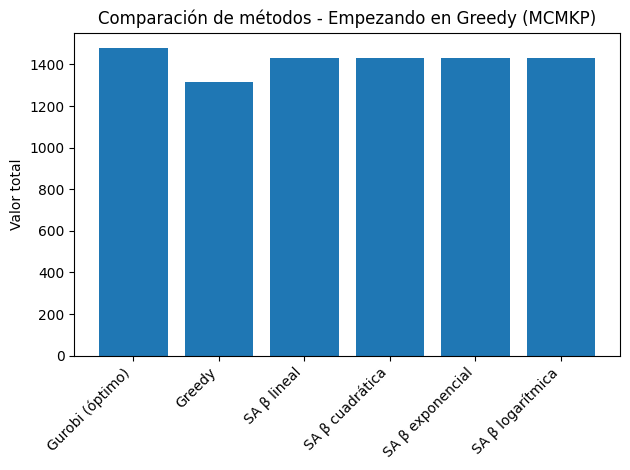

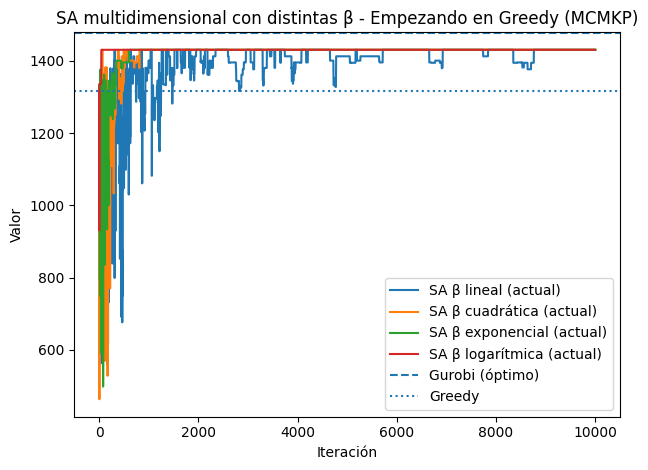

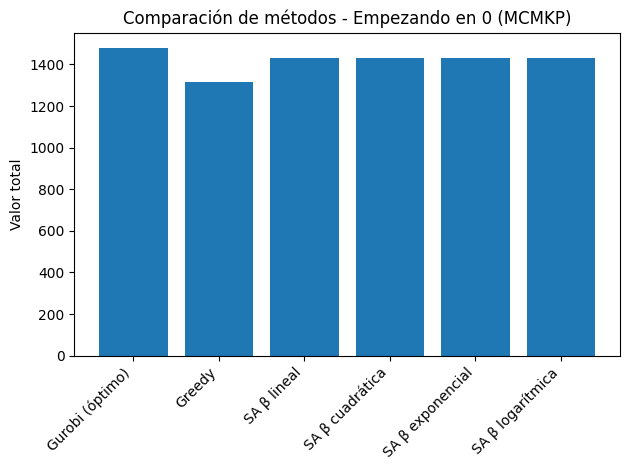

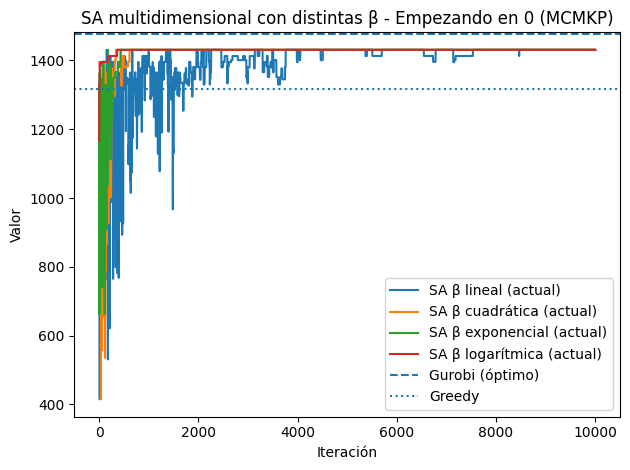

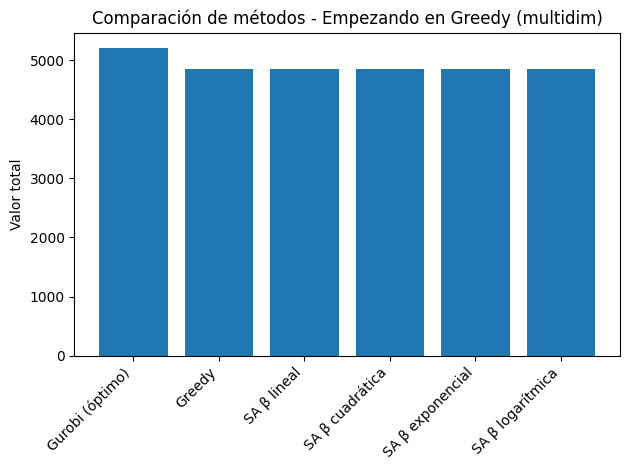

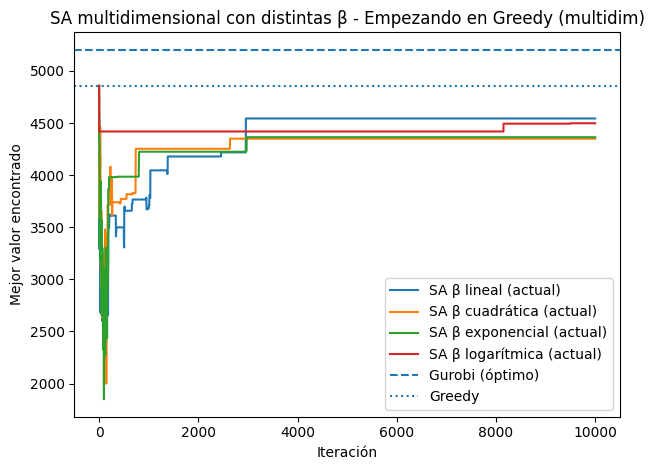

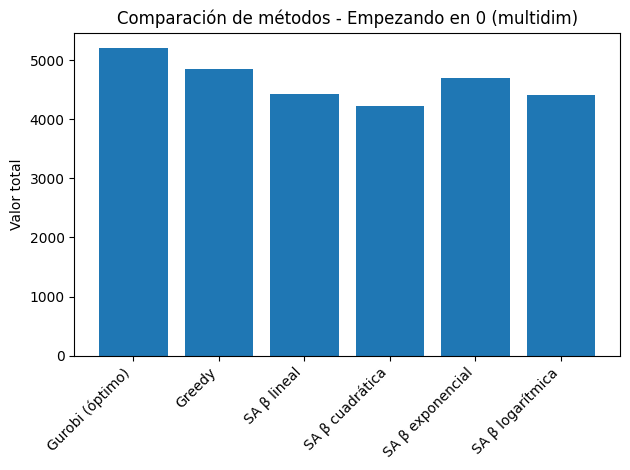

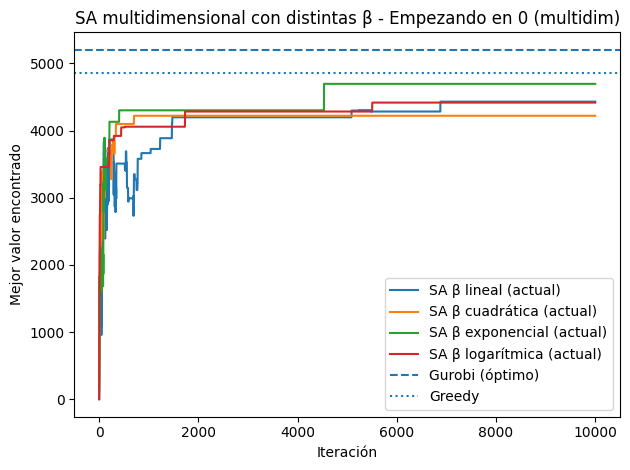

In [24]:
# Generate random data
np.random.seed(0)
n_items = 30
n_classes = 3
n_resources = 2

profits = np.random.randint(100, 500, size=(n_items, n_classes))
weights = np.random.randint(1, 100, size=(n_items, n_classes, n_resources))
capacities_mcmkp = np.random.randint(150, 250, size=n_resources)
capacities_mk = np.tile(capacities_mcmkp, (3, 1))  # Create capacities_mk by repeating capacities_mcmkp
classes = np.random.choice(n_classes, size=n_items, replace=True)

# Ensure that all classes are present
for c in range(n_classes):
    if c not in classes:
        classes[np.random.randint(n_items)] = c

# MCMKP with greedy
resultados_mcmkp_greedy = comparar_mcmkp_multidim(
    weights,
    profits,
    capacities_mcmkp,
    classes,
    T0=600,
    L=0.9999,
    iterations=10000,
    beta_funcs=beta_funcs,
    titulo_instancia="Empezando en Greedy (MCMKP)",
    start_with_greedy=True,
    plot_best=False
)

# MCMKP without greedy
resultados_mcmkp_no_greedy = comparar_mcmkp_multidim(
    weights,
    profits,
    capacities_mcmkp,
    classes,
    T0=600,
    L=0.9999,
    iterations=10000,
    beta_funcs=beta_funcs,
    titulo_instancia="Empezando en 0 (MCMKP)",
    start_with_greedy=False,
    plot_best=False
)

# MK with greedy
resultados_mk_greedy = comparar_mk_multidim(
    weights[:, 0, :],
    profits[:, 0],
    capacities_mk,
    T0=600,
    L=0.9999,
    iterations=10000,
    beta_funcs=beta_funcs,
    titulo_instancia="Empezando en Greedy (multidim)",
    start_with_greedy=True,
    plot_best=False
)

# MK without greedy
resultados_mk_no_greedy = comparar_mk_multidim(
    weights[:, 0, :],
    profits[:, 0],
    capacities_mk,
    T0=600,
    L=0.9999,
    iterations=10000,
    beta_funcs=beta_funcs,
    titulo_instancia="Empezando en 0 (multidim)",
    start_with_greedy=False,
    plot_best=False
)


Final Best Solution:
Class 0: Item 1 → Profit: 49, Weights: [8 1]
Class 1: Item 3 → Profit: 34, Weights: [6 7]
Class 2: Item 6 → Profit: 35, Weights: [5 5]
Total Profit: 118


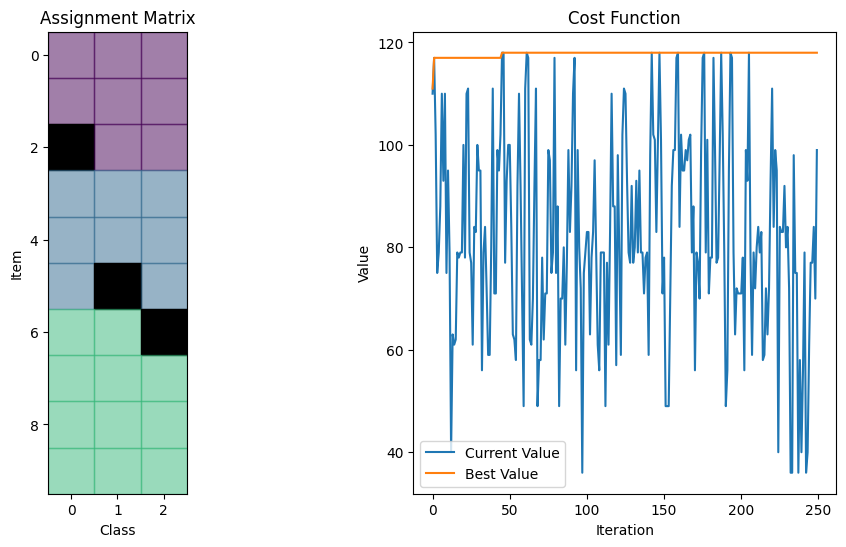

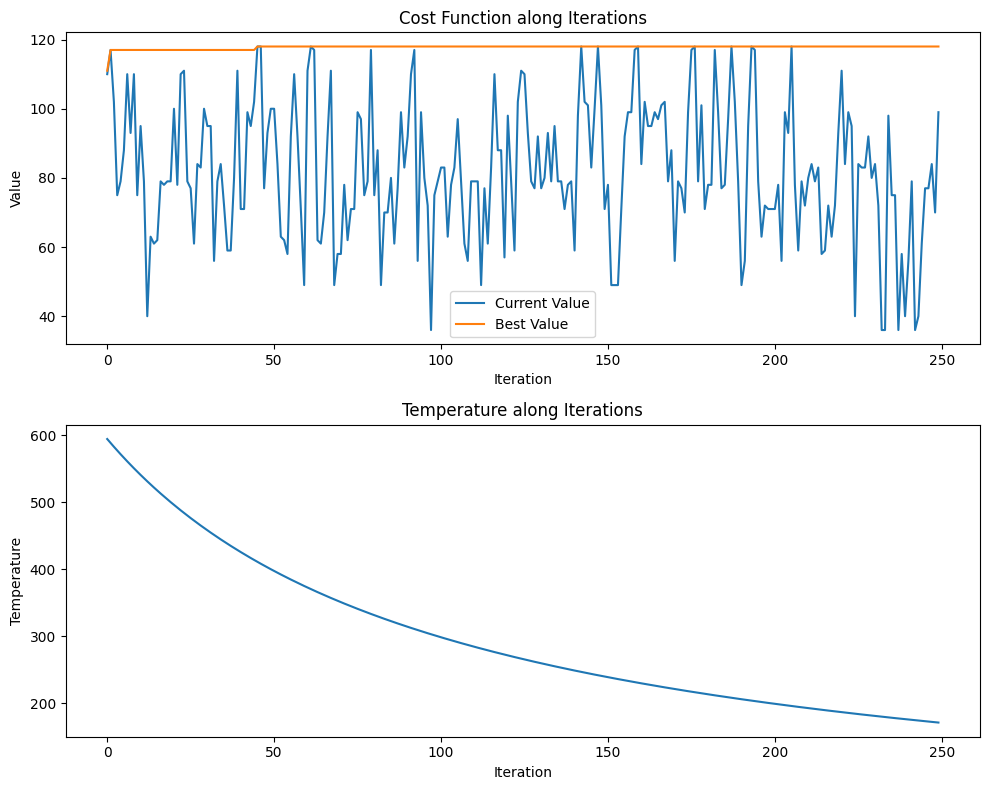

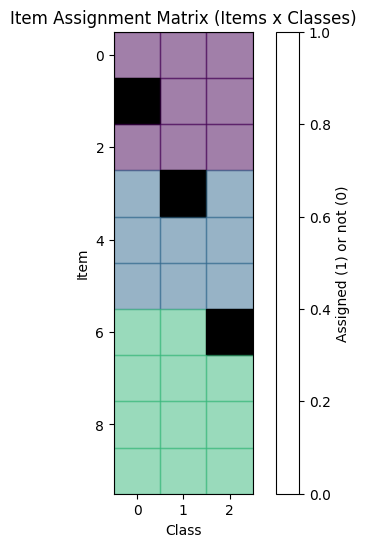

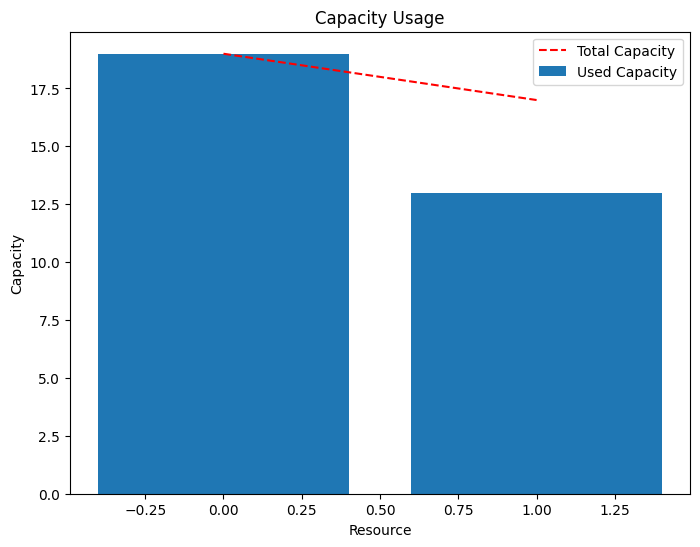


Final Best Solution:
Class 0: Item 1 → Profit: 49, Weights: [8 1]
Class 1: Item 3 → Profit: 34, Weights: [6 7]
Class 2: Item 6 → Profit: 35, Weights: [5 5]
Total Profit: 118


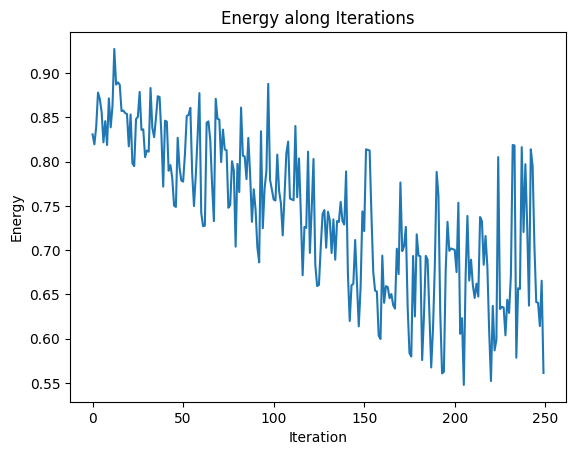

In [25]:
import numpy as np

# Define beta_func
def beta_lineal(t):
    return 1 + t/100

# Generate common data
it = 250
np.random.seed(0)
n_items = 10
n_classes = 3
n_resources = 2
profits = np.random.randint(10, 50, size=(n_items, n_classes))
weights = np.random.randint(1, 10, size=(n_items, n_classes, n_resources))
capacities_mcmkp = np.random.randint(15, 25, size=(n_resources,))
classes = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2])  # items 0-2 in class 0, items 3-5 in class 1, items 6-9 in class 2
capacities_mk = np.tile(capacities_mcmkp, (3, 1))  # Create capacities_mk by repeating capacities_mcmkp

# MCMKP problem
solver_mcmkp = MultipleChoiceMKP(profits, weights, capacities_mcmkp, classes, T=600, L=0.9999, start_with_greedy=False)
solver_mcmkp.run(iterations=it, verbose=True, beta_func=beta_lineal)
solver_mcmkp.animate_solution(filename='mcmkp_animation_beta_lineal_250.mp4')
solver_mcmkp.plot_cost_history()
solver_mcmkp.plot_assignment_matrix()
solver_mcmkp.plot_capacity_usage()
solver_mcmkp.print_solution(solver_mcmkp.best_solution)
solver_mcmkp.plot_energy()


Final Best Solution:
Knapsack 0:
  Item 1 → Value: 49, Weights: [8 1]
  Item 5 → Value: 49, Weights: [4 7]
  Item 7 → Value: 23, Weights: [4 5]
  Total weight used: [16 13] / Capacity: [19 17]
  Total value: 121

Knapsack 1:
  Item 3 → Value: 16, Weights: [5 6]
  Item 8 → Value: 30, Weights: [8 6]
  Item 9 → Value: 25, Weights: [4 1]
  Total weight used: [17 13] / Capacity: [19 17]
  Total value: 71

Knapsack 2:
  Item 0 → Value: 10, Weights: [4 9]
  Item 2 → Value: 31, Weights: [4 3]
  Item 4 → Value: 22, Weights: [2 5]
  Total weight used: [10 17] / Capacity: [19 17]
  Total value: 63

Overall packed value: 255


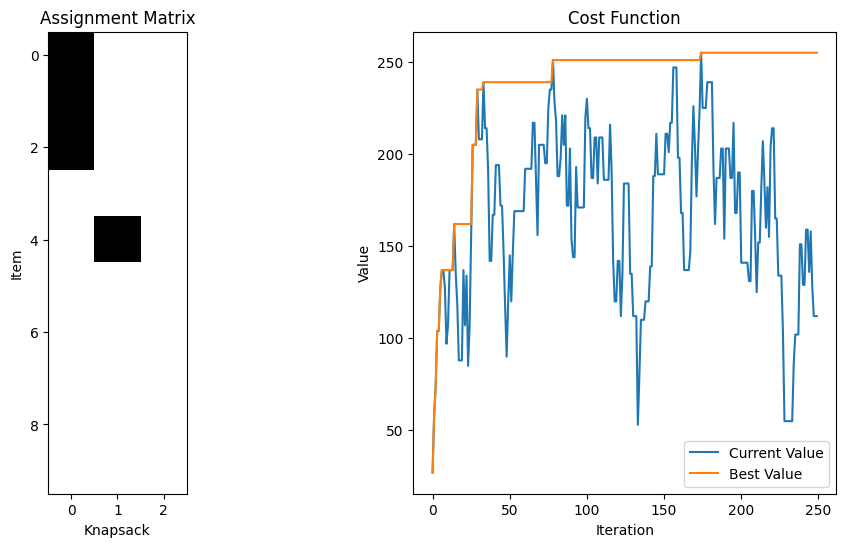

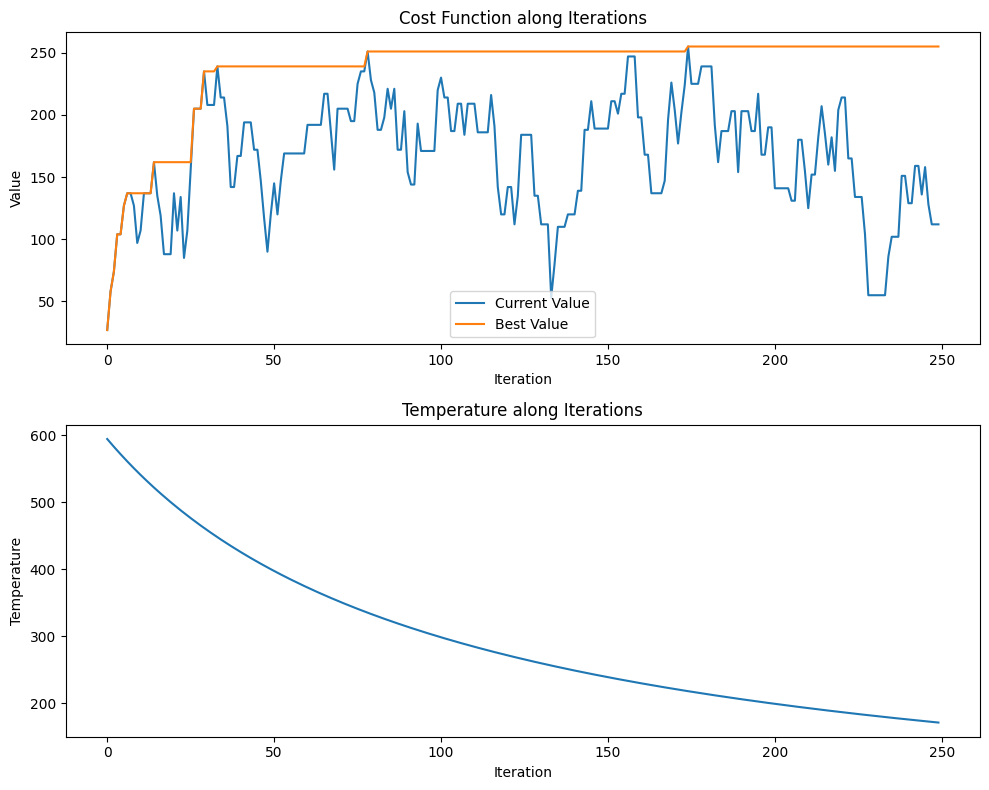

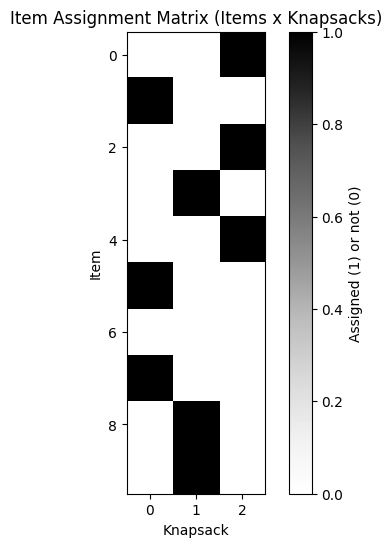

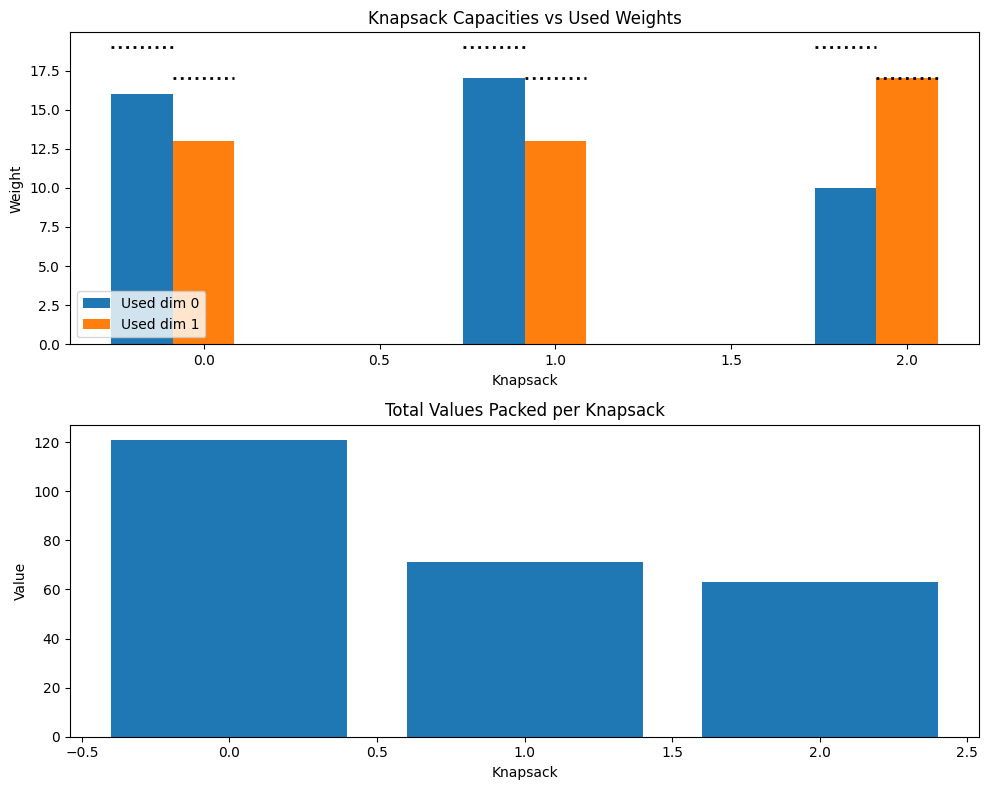


Final Best Solution:
Knapsack 0:
  Item 1 → Value: 49, Weights: [8 1]
  Item 5 → Value: 49, Weights: [4 7]
  Item 7 → Value: 23, Weights: [4 5]
  Total weight used: [16 13] / Capacity: [19 17]
  Total value: 121

Knapsack 1:
  Item 3 → Value: 16, Weights: [5 6]
  Item 8 → Value: 30, Weights: [8 6]
  Item 9 → Value: 25, Weights: [4 1]
  Total weight used: [17 13] / Capacity: [19 17]
  Total value: 71

Knapsack 2:
  Item 0 → Value: 10, Weights: [4 9]
  Item 2 → Value: 31, Weights: [4 3]
  Item 4 → Value: 22, Weights: [2 5]
  Total weight used: [10 17] / Capacity: [19 17]
  Total value: 63

Overall packed value: 255


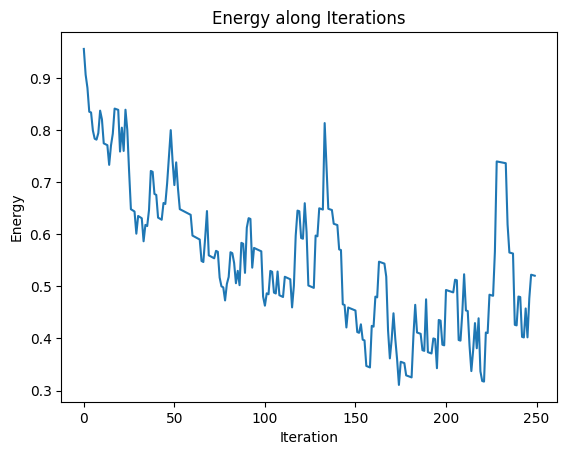

In [26]:
# MK problem
solver_mk = MultipleKnapsack(weights[:, 0, :], profits[:, 0], capacities_mk, T=600, L=0.9999, start_with_greedy=False)
solver_mk.run(iterations=it, verbose=True, beta_func=beta_lineal)
solver_mk.animate_solution(filename='mk_animation_beta_lineal_250.mp4')
solver_mk.plot_cost_history()
solver_mk.plot_assignment_matrix()
solver_mk.plot_knapsack_usage()
solver_mk.print_solution(solver_mk.best_solution)
solver_mk.plot_energy()

* code made with the help of AI (ロボットは人間にあたえられた命令に服従しなければならない。ただし、あたえられた命令が、第一条に反する場合は、この限りでない。)